In [2]:
import argparse
from pathlib import Path
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
import pandas as pd
import json
import pprint
import seaborn as sns
import torch

import torchmetrics
from torchmetrics import PrecisionRecallCurve, ROC
from torchmetrics.functional.classification import binary_auroc, multiclass_auroc, binary_precision_recall_curve, multiclass_precision_recall_curve, confusion_matrix
from torchmetrics.utilities.compute import _auc_compute_without_check, _auc_compute


/home/ylan/miniconda3/envs/pytorch2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
'''TransMIL'''
a = 'features'
add_on = '1'

task = 'norm_rest'
model = 'TransMIL'
version = '804'
epoch = '30'
labels = ['Disease']


# task = 'rest_rej'
# model = 'TransMIL'
# version = '63'
# epoch = '14'
# labels = ['Rejection']

# task = 'norm_rej_rest'
# model = 'TransMIL'
# version = '53'
# epoch = '17'
# labels = ['Normal', 'Rejection', 'Rest']

'''ViT'''
# a = 'vit'

# task = 'norm_rest'
# model = 'vit'
# version = '16'
# epoch = '142'
# labels = ['Disease']

# task = 'rej_rest'
# model = 'vit'
# version = '1'
# epoch = 'last'
# labels = ['Rest']

# task = 'norm_rej_rest'
# model = 'vit'
# version = '0'
# epoch = '226'
# labels = ['Normal', 'Rejection', 'Rest']

'''CLAM'''
# task = 'norm_rest'
# model = 'CLAM'
# labels = ['REST']

# task = 'rej_rest'
# model = 'CLAM'
# labels = ['REST']

# task = 'norm_rej_rest'
# model = 'CLAM'
# labels = ['NORMAL', 'REJECTION', 'REST']
# labels = ['Normal', 'Rejection', 'Rest']
# if task == 'norm_rest' or task == 'rej_rest':
#     n_classes = 2
#     PRC = torchmetrics.PrecisionRecallCurve(task='binary')
#     ROC = torchmetrics.ROC(task='binary')
# else: 
#     n_classes = 3
#     PRC = torchmetrics.PrecisionRecallCurve(task='multiclass', num_classes = n_classes)
#     ROC = torchmetrics.ROC(task='multiclass', num_classes=n_classes)




'CLAM'

In [4]:
'''Find Directory'''

home = Path.cwd().parts[1]
root_dir = f'/{home}/ylan/workspace/TransMIL-DeepGraft/logs/DeepGraft/{model}/{task}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}'
print(root_dir)
patient_result_csv_path = Path(root_dir) / 'TEST_RESULT_PATIENT.csv'
print(patient_result_csv_path)
threshold_csv_path = f'{root_dir}/val_thresholds.csv'

# patient_result_csv_path = Path(f'/{home}/ylan/workspace/HIA/logs/DeepGraft_Lancet/clam_mb/DEEPGRAFT_CLAMMB_TRAINFULL_{task}/RESULTS/TEST_RESULT_PATIENT_BASED_FULL.csv')
# threshold_csv_path = ''

output_dir = f'/{home}/ylan/workspace/TransMIL-DeepGraft/test/results/{model}/'
Path(output_dir).mkdir(parents=True, exist_ok=True)

patient_result = pd.read_csv(patient_result_csv_path)
pprint.pprint(patient_result)

probs = torch.from_numpy(np.array(patient_result[labels]))
probs = probs.squeeze()

print(probs)


#     probs = 
    
# probs = torch.transpose(probs, 0,1).squeeze()
target = torch.from_numpy(np.array(patient_result.yTrue))

#swap values for rest_rej for it to align
if task == 'rest_rej':
    probs = 1-probs
    target = -1 * (target-1)
    task = 'rej_rest'
if add_on == '0':
    target = -1 * (target-1)

# 
# target = torch.stack((fake_target, target), dim=1)
# print(target.shae)
# print(target)
# target = -1 * (target-1)
# print(target)



/home/ylan/workspace/TransMIL-DeepGraft/logs/DeepGraft/TransMIL/norm_rest/_features_CrossEntropyLoss/lightning_logs/version_804/test_epoch_30
/home/ylan/workspace/TransMIL-DeepGraft/logs/DeepGraft/TransMIL/norm_rest/_features_CrossEntropyLoss/lightning_logs/version_804/test_epoch_30/TEST_RESULT_PATIENT.csv
     Unnamed: 0        PATIENT  yTrue    Normal   Disease
0             0  KiBiAcREZZ331      1  0.135010  0.865234
1             1  KiBiAcVUFQ120      0  0.784180  0.215820
2             2  KiBiAcFZJQ730      1  0.203613  0.796387
3             3  KiBiAcNCMV110      1  0.269043  0.730957
4             4  KiBiAcTTVB560      1  0.050018  0.950195
..          ...            ...    ...       ...       ...
168         168  KiBiAcYEYR260      0  0.409424  0.590820
169         169  KiBiAcZHCX830      1  0.223022  0.776855
170         170  KiBiAcZKQY690      1  0.303223  0.696777
171         171  KiBiAcZRMP870      1  0.147217  0.852539
172         172  KiBiAcZUXX151      1  0.033478  0.966

In [5]:
from utils import get_roc_curve, get_pr_curve, get_confusion_matrix

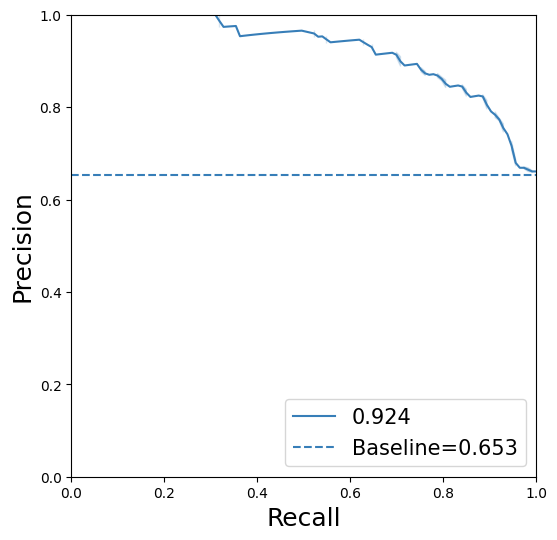

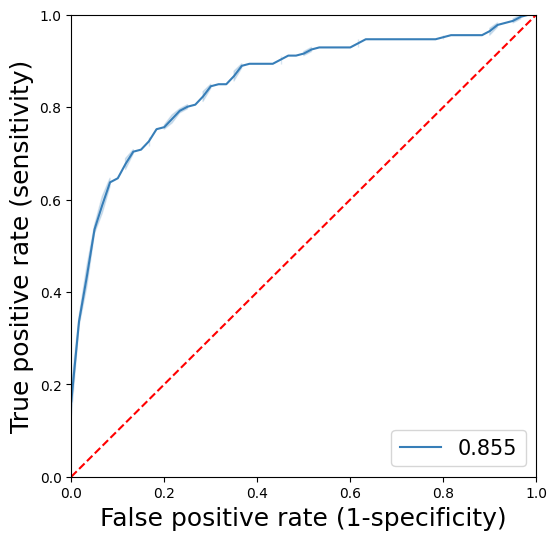

In [6]:
# from utils import get_roc_curve, get_pr_curve, get_confusion_matrix

stage='test'
comment='patient'
pr_plot = get_pr_curve(probs, target, task=task)
pr_plot.figure.savefig(f'{output_dir}/{task}_{add_on}_pr.png', dpi=400)
pr_plot.figure.savefig(f'{output_dir}/{task}_{add_on}_pr.svg', format='svg')
plt.show()

pr_plot.figure.clf()

roc_plot = get_roc_curve(probs, target, task=task)
roc_plot.legend(loc='lower right', fontsize=15)
roc_plot.figure.savefig(f'{output_dir}/{task}_{add_on}_roc.png', dpi=400)
roc_plot.figure.savefig(f'{output_dir}/{task}_{add_on}_roc.svg', format='svg')
plt.show()

roc_plot.figure.clf()

Optimal Threshold test patient:  0.7783203125


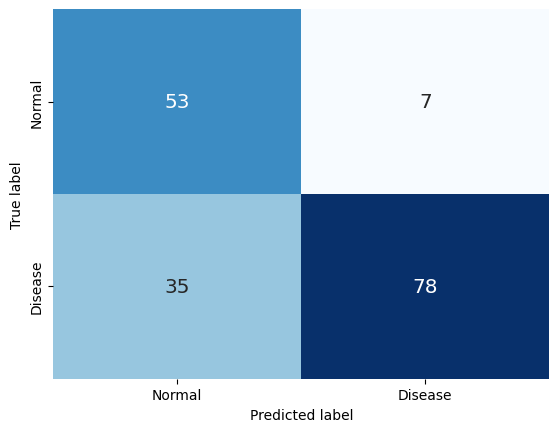

<Figure size 640x480 with 0 Axes>

In [7]:
stage = 'test'
comment='patient'

cm_plot = get_confusion_matrix(probs, target, task=task, threshold_csv_path = threshold_csv_path)

plt.show()
# cm_plot.figure.set(font_scale=18)
cm_plot.savefig(f'{output_dir}/{task}_cm.png', dpi=400)
cm_plot.savefig(f'{output_dir}/{task}_cm.svg', format='svg')

# plt.savefig(f'{output_dir}/{task}_cm.png', dpi=400)

cm_plot.clf()





In [8]:
# print((Path(output_dir)/task).stem)
# print(output_dir)
# model = 'vit'
# task = 'norm_rest'
# output_dir = f'/{home}/ylan/workspace/TransMIL-DeepGraft/test/results/{model}/'
# out_dir = Path(output_dir)/task
# for i in Path(out_dir).iterdir():
#     if i.is_file():
#         name = i.name.rsplit('_', 1)[1]
#         # print(i)
#         # print(i.parents[0])
#         new_name = Path(output_dir) / f'{task}_{name}'
#         print(new_name)
#         i.rename(new_name)
    # print(new_name)


In [9]:
from scipy.stats import bootstrap
import sklearn
res = bootstrap((patient_score.cpu().numpy(), patient_target.cpu().numpy()), sklearn.metrics.roc_auc_score, confidence_level=0.95, paired=True, vectorized=False)

print('bootstrap AUC: ', res)
patient_AUC = self.AUROC(patient_score, patient_target.squeeze())

NameError: name 'patient_score' is not defined